### DLP Lab1
#### Requirment
* Implement a simple neuron nerwork with forward pass and backpropagation
* Use sigmoid as activation function
* Test on two dataset
    * Linear
    * XOR
* Do not use any deep learning libraries such as Pytorch, Tensorflow
* Last modification: 2020/04/07

In [252]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x))

def derivate_sigmoid(x):
    return np.multiply(x, 1.0-x)

### Fetch data

In [253]:
class GenData:
    @staticmethod
    def _gen_linear(n=100):
        """ Data generation (Linear)

        Args:
            n (int):    the number of data points generated in total.

        Returns:
            data (np.ndarray, np.float):    the generated data with shape (n, 2). Each row represents
                a data point in 2d space.
            labels (np.ndarray, np.int):    the labels that correspond to the data with shape (n, 1).
                Each row represents a corresponding label (0 or 1).
        """
        data = np.random.uniform(0, 1, (n, 2))

        inputs = []
        labels = []

        for point in data:
            inputs.append([point[0], point[1]])

            if point[0] > point[1]:
                labels.append(0)
            else:
                labels.append(1)

        return np.array(inputs), np.array(labels).reshape((-1, 1))

    @staticmethod
    def _gen_xor(n=100):
        """ Data generation (XOR)

        Args:
            n (int):    the number of data points generated in total.

        Returns:
            data (np.ndarray, np.float):    the generated data with shape (n, 2). Each row represents
                a data point in 2d space.
            labels (np.ndarray, np.int):    the labels that correspond to the data with shape (n, 1).
                Each row represents a corresponding label (0 or 1).
        """
        data_x = np.linspace(0, 1, n // 2)

        inputs = []
        labels = []

        for x in data_x:
            inputs.append([x, x])
            labels.append(0)

            if x == 1 - x:
                continue

            inputs.append([x, 1 - x])
            labels.append(1)

        return np.array(inputs), np.array(labels).reshape((-1, 1))

    @staticmethod
    def fetch_data(mode, n):
        """ Data gather interface

        Args:
            mode (str): 'Linear' or 'XOR', indicate which generator is used.
            n (int):    the number of data points generated in total.
        """
        assert mode == 'Linear' or mode == 'XOR'

        data_gen_func = {
            'Linear': GenData._gen_linear,
            'XOR': GenData._gen_xor
        }[mode]

        return data_gen_func(n)

### Hidden layer

In [254]:
class HiddenLayer:
    def __init__(self, input_size, hidden_size):
        self.W = np.random.uniform(-1, 1, [input_size, hidden_size])
        self.b = np.zeros(hidden_size)
        self.x = None
        self.dW = None
        self.db = None
            
    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b
        self.out = sigmoid(out)
        return self.out
    
    def backward(self, dout):
        dout = dout * derivate_sigmoid(self.out)
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis = 0)
        return dx

### Network model

In [275]:
class NeuralNetwork():
    def __init__(self, input_size, hidden_size, num_step=2000, learning_rate=0.5, print_interval=100):
        self.num_step = num_step
        self.learning_rate = learning_rate
        self.print_interval = print_interval
        
        # initiate layers
        self.layers = []
        self.layers.append(HiddenLayer(input_size, hidden_size))
        self.layers.append(HiddenLayer(hidden_size, hidden_size))
        self.lastLayer = HiddenLayer(hidden_size, 1)
        
    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return self.lastLayer.forward(x)
        
    def backward(self):
        # calculate gradients
        dout = self.lastLayer.backward(self.error)
        layers = list(self.layers)
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
                
        # update weights
        self.lastLayer.W -= self.learning_rate * self.lastLayer.dW
        self.lastLayer.b -= self.learning_rate * self.lastLayer.db
        for layer in self.layers:
            layer.W -= self.learning_rate * layer.dW
            layer.b -= self.learning_rate * layer.db
        
    def training(self, inputs, labels):
        loss_list = []
        acc_list = []
        for epochs in range(self.num_step):
            for idx in range(inputs.shape[0]):
                self.output = self.forward(inputs[idx:idx+1, :])
                self.error = self.output - labels[idx]
                self.backward()
            
            if epochs % self.print_interval == 0:
                loss = self.loss(inputs, labels)
                acc = self.accuracy(inputs, labels)
                loss_list.append(loss)
                acc_list.append(acc)
                print ("Epochs: %4s, loss: %.10f, acc: %.10f"%
                       (epochs, loss, acc))
                
        return loss_list, acc_list

    # calculate the loss
    def loss(self, inputs, labels):
        return np.sum(np.square(self.predict(inputs)-labels)) / labels.shape[0]
    
    # reutrn the predict value
    def predict(self, inputs):
        output = []
        for idx in range(inputs.shape[0]):
            output.append(self.forward(inputs[idx:idx+1, :]))
        output = np.array(output).reshape(inputs.shape[0], 1)
        return output
        
    # return the predict label
    def get_output(self, inputs):
        return  np.around(self.predict(inputs))
    
    # calculate accuracy
    def accuracy(self, inputs, labels):
        return np.sum(self.get_output(inputs) == label) / float(inputs.shape[0])
         
    @staticmethod
    def show_result(x, y, pred_y):
        assert x.shape[0] == y.shape[0]
        assert x.shape[0] == pred_y.shape[0]

        plt.figure()

        plt.subplot(1, 2, 1)
        plt.title('Ground truth', fontsize=18)
        for i in range(x.shape[0]):
            if y[i] == 0:
                plt.plot(x[i][0], x[i][1], 'ro')
            else:
                plt.plot(x[i][0], x[i][1], 'bo')

        plt.subplot(1, 2, 2)
        plt.title('Predict result', fontsize=18)
        for i in range(x.shape[0]):
            if pred_y[i] == 0:
                plt.plot(x[i][0], x[i][1], 'ro')
            else:
                plt.plot(x[i][0], x[i][1], 'bo')

        plt.show()
        
    @staticmethod
    def show_loss_acc(loss, acc):
        plt.figure()
        
        plt.subplot(1, 2, 1)
        plt.title('Loss', fontsize=18)
        plt.plot(loss)
        plt.subplot(1, 2, 2)
        plt.title('Accuracy', fontsize=18)
        plt.plot(acc)
        plt.show()

### Linear data

Epochs:    0, loss: 0.2592759866, acc: 0.5285714286
Epochs:  100, loss: 0.0261918253, acc: 0.9571428571
Epochs:  200, loss: 0.0190916300, acc: 0.9571428571
Epochs:  300, loss: 0.0115127412, acc: 0.9857142857
Epochs:  400, loss: 0.0075776451, acc: 0.9857142857
Epochs:  500, loss: 0.0056884206, acc: 1.0000000000
Epochs:  600, loss: 0.0045796682, acc: 1.0000000000
Epochs:  700, loss: 0.0037978795, acc: 1.0000000000
Epochs:  800, loss: 0.0031254848, acc: 1.0000000000
Epochs:  900, loss: 0.0024625331, acc: 1.0000000000
Epochs: 1000, loss: 0.0018422807, acc: 1.0000000000
Epochs: 1100, loss: 0.0013722480, acc: 1.0000000000
Epochs: 1200, loss: 0.0010653891, acc: 1.0000000000
Epochs: 1300, loss: 0.0008664352, acc: 1.0000000000
Epochs: 1400, loss: 0.0007306822, acc: 1.0000000000
Epochs: 1500, loss: 0.0006328418, acc: 1.0000000000
Epochs: 1600, loss: 0.0005590190, acc: 1.0000000000
Epochs: 1700, loss: 0.0005012439, acc: 1.0000000000
Epochs: 1800, loss: 0.0004546938, acc: 1.0000000000
Epochs: 1900

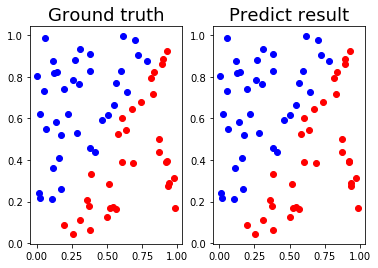

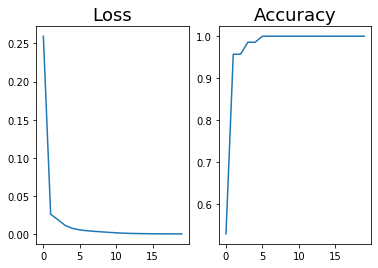

In [278]:
data, label = GenData.fetch_data('Linear', 70)

net = NeuralNetwork(input_size=data.shape[1], hidden_size=100, num_step=2000, learning_rate=0.1, print_interval=100)
loss, acc = net.training(data, label)

pred_y = net.get_output(data)
NeuralNetwork.show_result(data, label, pred_y)
NeuralNetwork.show_loss_acc(loss, acc)

In [279]:
print(net.predict(data))

[[9.99946751e-01]
 [3.24780850e-02]
 [9.99938490e-01]
 [9.26230354e-01]
 [9.05193177e-13]
 [1.00000000e+00]
 [9.99999996e-01]
 [3.20899842e-06]
 [8.84172413e-01]
 [8.31329897e-10]
 [1.00000000e+00]
 [1.00000000e+00]
 [4.02595046e-10]
 [9.99999976e-01]
 [5.31996482e-04]
 [1.00000000e+00]
 [9.99999984e-01]
 [3.58272385e-11]
 [9.99999237e-01]
 [1.69881843e-13]
 [9.99999873e-01]
 [2.30257701e-04]
 [9.99461689e-01]
 [1.00000000e+00]
 [9.99990017e-01]
 [1.00000000e+00]
 [1.00000000e+00]
 [3.51432313e-14]
 [1.00000000e+00]
 [1.92136121e-03]
 [2.38219093e-03]
 [1.00000000e+00]
 [1.00000000e+00]
 [7.17156802e-08]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.37303860e-13]
 [1.45107033e-13]
 [7.36290112e-08]
 [2.39566251e-03]
 [5.72389126e-11]
 [1.00000000e+00]
 [9.99872167e-01]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.78701398e-10]
 [9.99999995e-01]
 [1.03187757e-04]
 [3.43448170e-05]
 [9.97743663e-01]
 [4.23700098e-03]
 [1.57769414e-10]
 [3.72843781e-09]
 [1.00000000e+00]
 [3.30336798e-06]
 [3.017930

### XOR data

Epochs:    0, loss: 0.4643875291, acc: 0.4927536232
Epochs:  100, loss: 0.0805500120, acc: 0.8985507246
Epochs:  200, loss: 0.0462950210, acc: 0.9420289855
Epochs:  300, loss: 0.0332038706, acc: 0.9565217391
Epochs:  400, loss: 0.0260660157, acc: 0.9710144928
Epochs:  500, loss: 0.0212890340, acc: 0.9710144928
Epochs:  600, loss: 0.0180416048, acc: 0.9710144928
Epochs:  700, loss: 0.0158376465, acc: 0.9710144928
Epochs:  800, loss: 0.0141458011, acc: 0.9710144928
Epochs:  900, loss: 0.0126736908, acc: 0.9855072464
Epochs: 1000, loss: 0.0112977517, acc: 0.9855072464
Epochs: 1100, loss: 0.0099845754, acc: 1.0000000000
Epochs: 1200, loss: 0.0087443973, acc: 1.0000000000
Epochs: 1300, loss: 0.0075871763, acc: 1.0000000000
Epochs: 1400, loss: 0.0065031652, acc: 1.0000000000
Epochs: 1500, loss: 0.0054678558, acc: 1.0000000000
Epochs: 1600, loss: 0.0044812972, acc: 1.0000000000
Epochs: 1700, loss: 0.0036074233, acc: 1.0000000000
Epochs: 1800, loss: 0.0029104067, acc: 1.0000000000
Epochs: 1900

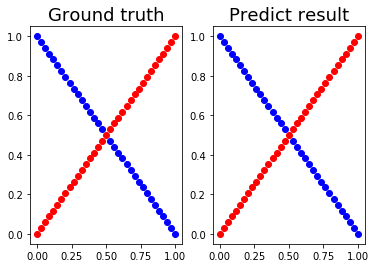

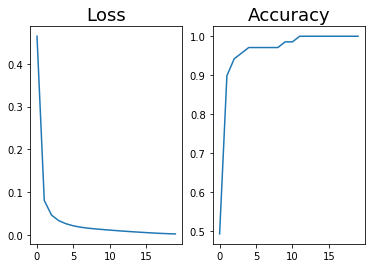

In [280]:
data, label = GenData.fetch_data('XOR', 70)

net = NeuralNetwork(input_size=data.shape[1], hidden_size=100, num_step=2000, learning_rate=0.1, print_interval=100)
loss, acc = net.training(data, label)

pred_y = net.get_output(data)
NeuralNetwork.show_result(data, label, pred_y)
NeuralNetwork.show_loss_acc(loss, acc)

In [281]:
print(net.predict(data))

[[0.00173169]
 [0.99999171]
 [0.00194495]
 [0.99999156]
 [0.00220376]
 [0.99999126]
 [0.00251775]
 [0.99999079]
 [0.00289854]
 [0.9999901 ]
 [0.00336081]
 [0.99998914]
 [0.00392529]
 [0.99998784]
 [0.00462648]
 [0.99998607]
 [0.00553159]
 [0.99998366]
 [0.00678543]
 [0.9999803 ]
 [0.00871649]
 [0.99997534]
 [0.01209148]
 [0.99996719]
 [0.01871123]
 [0.99995119]
 [0.03251398]
 [0.99990906]
 [0.05981468]
 [0.99972608]
 [0.10265113]
 [0.99759526]
 [0.1452053 ]
 [0.83260731]
 [0.15980236]
 [0.13557151]
 [0.8677843 ]
 [0.09017711]
 [0.99683043]
 [0.05043532]
 [0.99950914]
 [0.02681781]
 [0.99984714]
 [0.01511277]
 [0.99993672]
 [0.00944757]
 [0.99996819]
 [0.0065183 ]
 [0.99998146]
 [0.00484707]
 [0.99998794]
 [0.00379676]
 [0.99999151]
 [0.0030817 ]
 [0.99999364]
 [0.00256455]
 [0.99999502]
 [0.00217372]
 [0.99999594]
 [0.00186873]
 [0.99999659]
 [0.00162495]
 [0.99999705]
 [0.00142648]
 [0.99999739]
 [0.00126254]
 [0.99999765]
 [0.00112555]
 [0.99999784]]
